In [152]:
#! pip -q install pandas matplotlib
#! pip install -q scikit-learn
#! pip install -q joblib
#! pip install -q tensorflow

In [153]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

WAREHOUSE = "Frankfurt_1"

pd.set_option('display.max_columns', None)

train_df_raw = pd.read_csv("data/train.csv")
train_calendar_df_raw = pd.read_csv("data/train_calendar.csv")
test_df_raw = pd.read_csv("data/test.csv")
test_calendar_df_raw = pd.read_csv("data/test_calendar.csv")

train_df_raw['date'] = pd.to_datetime(train_df_raw['date'])
train_calendar_df_raw['date'] = pd.to_datetime(train_calendar_df_raw['date'])
test_df_raw['date'] = pd.to_datetime(test_df_raw['date'])
test_calendar_df_raw['date'] = pd.to_datetime(test_calendar_df_raw['date'])

### Optional Dataset Validation

Evaluate the data correctness. Check both .csvs if their values in the same columns match and then merge them into one dataset.

In [154]:
def merge_csv(train_df, train_calendar_df):
    # Identify common columns
    common_columns = set(train_df.columns).intersection(set(train_calendar_df.columns))
    print(common_columns)

    # Merg the two datasets on warehouse and date
    merged_df_to_test = pd.merge(train_df, train_calendar_df, on=['date', 'warehouse'], suffixes=('_train', '_calendar'))
    
        # Compare values in common columns
    differences = {}
    for column in common_columns:
        if column not in ['date', 'warehouse']:  # Exclude join keys from comparison
            train_col = f"{column}_train"
            calendar_col = f"{column}_calendar"
            
            # Check if there are any differences, excluding rows where both values are NaN
            diff = merged_df_to_test[(merged_df_to_test[train_col] != merged_df_to_test[calendar_col]) & 
                            (~merged_df_to_test[train_col].isna() | ~merged_df_to_test[calendar_col].isna())]
            if not diff.empty:
                differences[column] = diff[['date', 'warehouse', train_col, calendar_col]]
            else:
                print(f"No differences found in column: {column}")

    # Display only the rows where values were different
    for col, diff in differences.items():
        print(f"\nNot merged. Differences found in column: {col}")
        print(diff)
        return

    if not differences:
        print("\nSuccess. All values match across the datasets, datasets merged.")
        return pd.merge(train_df, train_calendar_df, on=list(common_columns))


In [155]:
# Merg the two datasets on 'date' and 'warehouse' to facilitate comparison
train_df_merged = merge_csv(train_df_raw, train_calendar_df_raw)
test_df_merged = merge_csv(test_df_raw, test_calendar_df_raw) 

{'blackout', 'winter_school_holidays', 'holiday', 'mini_shutdown', 'shops_closed', 'school_holidays', 'mov_change', 'warehouse', 'date', 'frankfurt_shutdown', 'snow', 'precipitation', 'shutdown', 'holiday_name'}
No differences found in column: blackout
No differences found in column: winter_school_holidays
No differences found in column: holiday
No differences found in column: mini_shutdown
No differences found in column: shops_closed
No differences found in column: school_holidays
No differences found in column: mov_change
No differences found in column: frankfurt_shutdown
No differences found in column: snow
No differences found in column: precipitation
No differences found in column: shutdown
No differences found in column: holiday_name

Success. All values match across the datasets, datasets merged.
{'winter_school_holidays', 'shops_closed', 'holiday', 'school_holidays', 'date', 'warehouse', 'holiday_name'}
No differences found in column: winter_school_holidays
No differences found

In [156]:
train_df = train_df_merged.sort_values(by=['date', 'warehouse'])
test_df = test_df_merged.sort_values(by=['date', 'warehouse'])

### Drop unnecesary data

There are some data in the training set that will not be availiable in the testing / inference data inputs.

In [157]:
# get features that are not available in the test dataset
unavailable_features = list(set(train_df.columns).difference(set(test_df.columns)))    
unavailable_features.remove('orders')

print(f"Common features: {unavailable_features}")

Common features: ['blackout', 'user_activity_2', 'mini_shutdown', 'mov_change', 'user_activity_1', 'frankfurt_shutdown', 'snow', 'precipitation', 'shutdown', 'warehouse_limited']


In [158]:
train_df = train_df.drop(columns=unavailable_features)

In [159]:
# list redundant columns that have unchanging values
unchanging_columns = []
for column in train_df.columns:
    if train_df[column].nunique() == 1:
        unchanging_columns.append(column)
print(unchanging_columns)

train_df = train_df.drop(columns=unchanging_columns)

[]


In [160]:
# find out if there are changing values in column "school_holiday"
print(train_df['winter_school_holidays'].value_counts())

winter_school_holidays
0    7120
1     220
Name: count, dtype: int64


In [161]:
print(train_df.columns)
print(f"train data: {train_df.shape}")
print(f"test data: {test_df.shape}")

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')
train data: (7340, 9)
test data: (397, 8)


In [162]:
print(train_df.isnull().sum())
print(test_df.isnull().sum())

warehouse                    0
date                         0
orders                       0
holiday_name              7122
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
id                           0
dtype: int64
warehouse                   0
date                        0
holiday_name              380
holiday                     0
shops_closed                0
winter_school_holidays      0
school_holidays             0
id                          0
dtype: int64


In [163]:
test_df.head()

,warehouse,date,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
61,Brno_1,2024-03-16,NaN,0,0,0,0,Brno_1_2024-03-16
340,Budapest_1,2024-03-16,NaN,0,0,0,0,Budapest_1_2024-03-16
292,Frankfurt_1,2024-03-16,NaN,0,0,0,0,Frankfurt_1_2024-03-16
244,Munich_1,2024-03-16,NaN,0,0,0,0,Munich_1_2024-03-16
0,Prague_1,2024-03-16,NaN,0,0,0,0,Prague_1_2024-03-16


In [164]:
# What is the gap between the date of the last training data and the first test data?
train_max_date = train_df['date'].max()
test_min_date = test_df['date'].min()
print(f"Train max date: {train_max_date}")
print(f"Test min date: {test_min_date}")
print(f"Gap: {test_min_date - train_max_date}")

Train max date: 2024-03-15 00:00:00
Test min date: 2024-03-16 00:00:00
Gap: 1 days 00:00:00


In [165]:
train_df.columns

Index(['warehouse', 'date', 'orders', 'holiday_name', 'holiday',
       'shops_closed', 'winter_school_holidays', 'school_holidays', 'id'],
      dtype='object')

In [166]:
# merge the two datasets to facilitate data preprocessing and lag features generation   
train_df = pd.concat([train_df, test_df], axis=0)

In [167]:
train_df = train_df.sort_values(by=['date', 'warehouse'])

In [168]:
# only get data with "warehouse == Prague_1"  for the dataset
train_df = train_df[train_df['warehouse'] == WAREHOUSE]


In [169]:
train_df.head(10)

,warehouse,date,orders,holiday_name,holiday,shops_closed,winter_school_holidays,school_holidays,id
5557,Frankfurt_1,2022-02-18,929.0,NaN,0,0,0,0,Frankfurt_1_2022-02-18
5558,Frankfurt_1,2022-02-19,931.0,NaN,0,0,0,0,Frankfurt_1_2022-02-19
5559,Frankfurt_1,2022-02-23,945.0,NaN,0,0,0,0,Frankfurt_1_2022-02-23
5560,Frankfurt_1,2022-02-24,955.0,NaN,0,0,0,0,Frankfurt_1_2022-02-24
5561,Frankfurt_1,2022-02-25,1022.0,NaN,0,0,0,0,Frankfurt_1_2022-02-25
5562,Frankfurt_1,2022-02-26,1011.0,NaN,0,0,0,0,Frankfurt_1_2022-02-26
5563,Frankfurt_1,2022-02-28,1016.0,NaN,0,0,0,0,Frankfurt_1_2022-02-28
5564,Frankfurt_1,2022-03-01,971.0,NaN,0,0,0,0,Frankfurt_1_2022-03-01
5565,Frankfurt_1,2022-03-02,956.0,NaN,0,0,0,0,Frankfurt_1_2022-03-02
5566,Frankfurt_1,2022-03-03,972.0,NaN,0,0,0,0,Frankfurt_1_2022-03-03


In [170]:
# merge school_holiday and winter_schoolholiday into a single feature
#train_df['school_holiday'] = train_df['school_holidays'] | train_df['winter_school_holidays']
#train_df = train_df.drop(columns=['school_holidays', 'winter_school_holidays'])

In [171]:
from math import pi

def process_date(df):
    df.index = df.pop('date')
    
    df['quarter'] = df.index.quarter
    df['year'] = df.index.year
    df['month'] = df.index.month
    df['day'] = df.index.day
    df['day_of_week'] = df.index.dayofweek
    df['day_of_year'] = df.index.dayofyear
    df['is_weekend'] = df['day_of_week'].isin([5, 6]).astype(int)
    
    df['days_since_start'] = (df.index - df.index.min()).days
    
    df['year_sin'] = df['year'] * np.sin(2 * pi * df['year'])
    df['year_cos'] = df['year'] * np.cos(2 * pi * df['year'])
    df['month_sin'] = df['month'] * np.sin(2 * pi * df['month'])
    df['month_cos'] = df['month'] * np.cos(2 * pi * df['month'])
    #df['day_sin'] = df['day'] * np.sin(2 * pi * df['day'])
    #df['day_cos'] = df['day'] * np.cos(2 * pi * df['day'])
    
    time_features = ['day', 'days_since_start', 'month', 'day_of_year', 'year_sin', 'year_cos', 'month_sin', 'month_cos']
    categorical_features = ['day_of_week', 'quarter', 'year'] 
    return df, time_features, categorical_features

### Features categories:
- time_features
- numerical_features
- categorical_features

In [172]:
train_df, time_features, categorical_features=process_date(train_df)

In [173]:
train_df['holiday_name'].fillna('noholiday', inplace=True)

In [174]:
train_df = train_df.drop(columns=['holiday_name']) 

### Plot

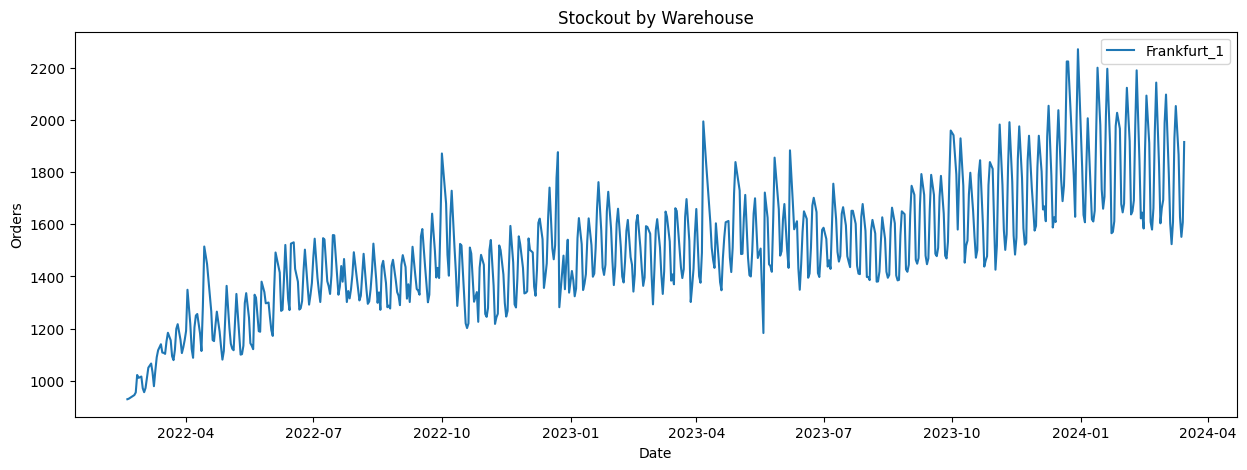

In [175]:
# Visualise the data
plt.figure(figsize=(15, 5))
for warehouse in train_df['warehouse'].unique():
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    plt.plot(warehouse_df.index, warehouse_df['orders'], label=warehouse)
plt.title("Stockout by Warehouse")
plt.xlabel("Date")
plt.ylabel("Orders")
plt.legend()
plt.show()

In [176]:
train_df['orders'].describe()

count     629.000000
mean     1499.068362
std       232.918694
min       929.000000
25%      1354.000000
50%      1480.000000
75%      1627.000000
max      2272.000000
Name: orders, dtype: float64

<Axes: title={'center': 'Distribution'}, xlabel='Orders', ylabel='Frequency'>

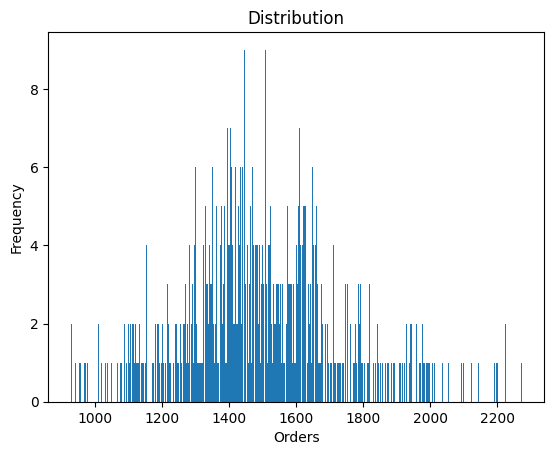

In [177]:
train_df['orders'].plot(kind='hist', bins=500, title='Distribution', xlabel='Orders')

<Axes: xlabel='date'>

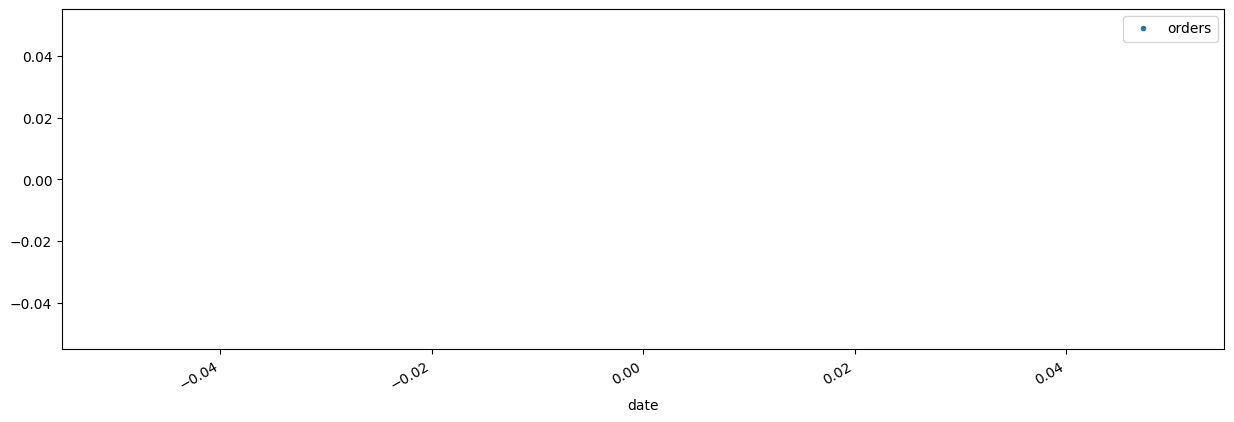

In [178]:
train_df.query('orders > 10000').plot(y='orders', figsize=(15, 5), style='.')

In [179]:

Q1 = train_df['orders'].quantile(0.25)
Q3 = train_df['orders'].quantile(0.75)
IQR = Q3 - Q1


lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 2.1 * IQR


iqr_outliers = train_df[(train_df['orders'] < lower_bound) | (train_df['orders'] > upper_bound)]

# Print number of outliers identified by each method
print(f"Number of IQR outliers: {iqr_outliers.shape[0]}")

iqr_outliers.head()


Number of IQR outliers: 6


,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,
2022-02-18,Frankfurt_1,929.0,0,0,0,0,Frankfurt_1_2022-02-18,1,2022,2,18,4,49,0,0,-2.639248e-09,2022.0,-9.797174e-16,2.0
2022-02-19,Frankfurt_1,931.0,0,0,0,0,Frankfurt_1_2022-02-19,1,2022,2,19,5,50,1,1,-2.639248e-09,2022.0,-9.797174e-16,2.0
2023-12-22,Frankfurt_1,2225.0,0,0,0,0,Frankfurt_1_2023-12-22,4,2023,12,22,4,356,0,672,-1.304240e-09,2023.0,-3.526983e-14,12.0
2023-12-23,Frankfurt_1,2225.0,0,0,0,0,Frankfurt_1_2023-12-23,4,2023,12,23,5,357,1,673,-1.304240e-09,2023.0,-3.526983e-14,12.0
2023-12-30,Frankfurt_1,2272.0,0,0,0,0,Frankfurt_1_2023-12-30,4,2023,12,30,5,364,1,680,-1.304240e-09,2023.0,-3.526983e-14,12.0


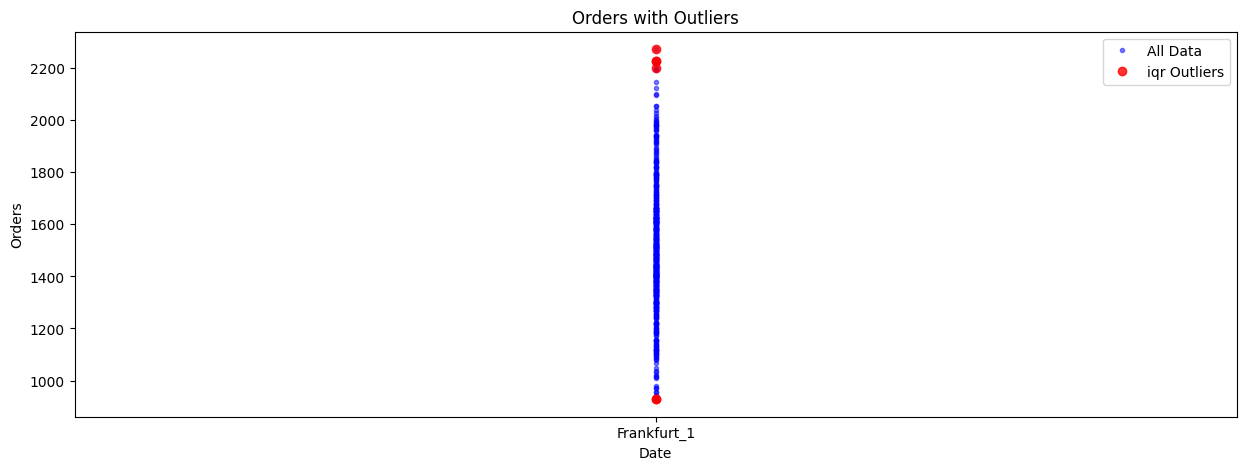

In [180]:
# Plot all data points
plt.figure(figsize=(15, 5))
plt.plot(train_df.warehouse, train_df['orders'], 'b.', alpha=0.5, label='All Data')

# Highlight outliers
plt.plot(iqr_outliers.warehouse, iqr_outliers['orders'], 'ro', alpha=0.8, label='iqr Outliers')


# Add labels and legend
plt.xlabel('Date')
plt.ylabel('Orders')
plt.title('Orders with Outliers')
plt.legend()
plt.show()

In [181]:
# Drop outliers
#train_df = train_df.drop(iqr_outliers.index)

# Do not drop outliers but fix their values to be average

train_df.loc[iqr_outliers.index, 'orders'] = train_df['orders'].mean()

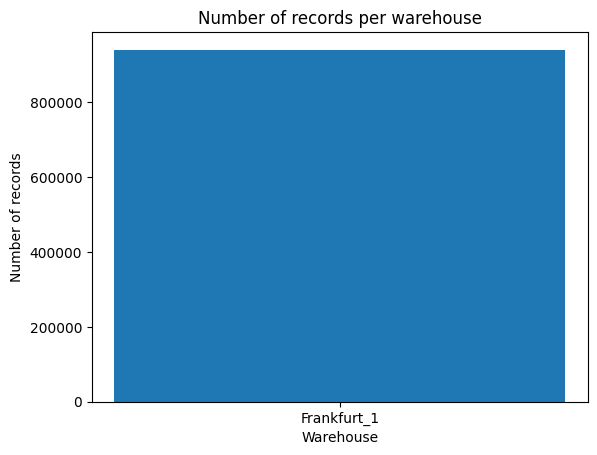

In [182]:
whs = train_df.groupby('warehouse')['orders'].sum()

plt.bar(whs.index, whs.values)
plt.xlabel('Warehouse')
plt.ylabel('Number of records')
plt.title('Number of records per warehouse')
plt.show()

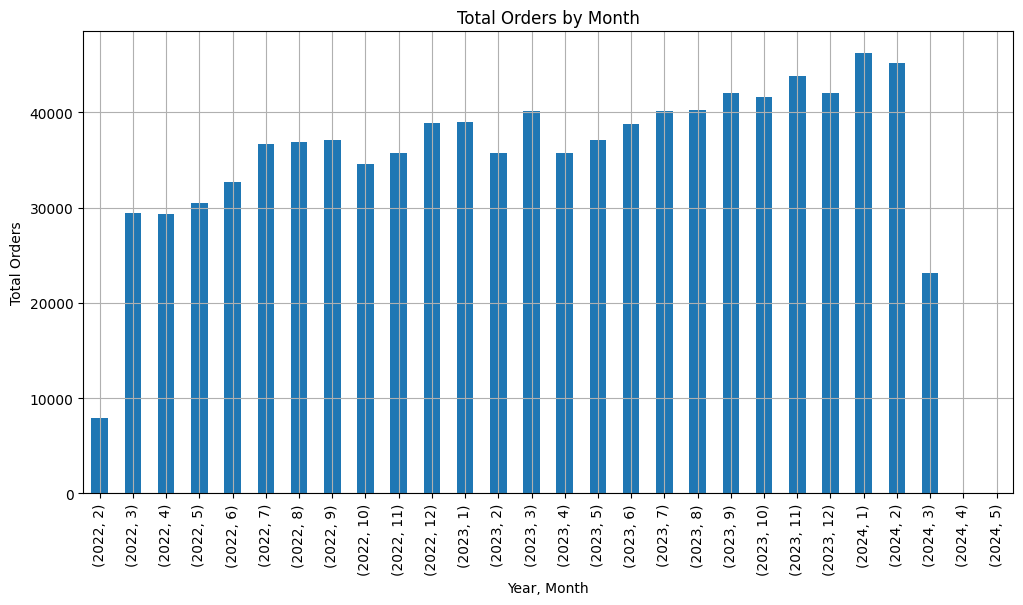

In [183]:
# plot the orders
df_by_month = train_df.groupby(['year', 'month'])['orders'].sum()
df_by_month.plot(kind='bar', figsize=(12, 6))

plt.title('Total Orders by Month')
plt.ylabel('Total Orders')
plt.xlabel('Year, Month')
plt.xticks(np.arange(len(df_by_month)), df_by_month.index, rotation=90)
plt.grid(True)
plt.show()

In [184]:
# remove the 3. month of the 2024 of the dataset
latest_date = train_df.index.max()
first_of_last_month = latest_date.replace(day=1)
# Filter out the rows from the last month
#train_df = train_df[train_df.index < first_of_last_month]

train_df.tail()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,
2024-05-10,Frankfurt_1,NaN,0,0,0,0,Frankfurt_1_2024-05-10,2,2024,5,10,4,131,0,812,3.208798e-11,2024.0,-6.123234e-15,5.0
2024-05-11,Frankfurt_1,NaN,0,0,0,0,Frankfurt_1_2024-05-11,2,2024,5,11,5,132,1,813,3.208798e-11,2024.0,-6.123234e-15,5.0
2024-05-13,Frankfurt_1,NaN,0,0,0,0,Frankfurt_1_2024-05-13,2,2024,5,13,0,134,0,815,3.208798e-11,2024.0,-6.123234e-15,5.0
2024-05-14,Frankfurt_1,NaN,0,0,0,0,Frankfurt_1_2024-05-14,2,2024,5,14,1,135,0,816,3.208798e-11,2024.0,-6.123234e-15,5.0
2024-05-15,Frankfurt_1,NaN,0,0,0,0,Frankfurt_1_2024-05-15,2,2024,5,15,2,136,0,817,3.208798e-11,2024.0,-6.123234e-15,5.0


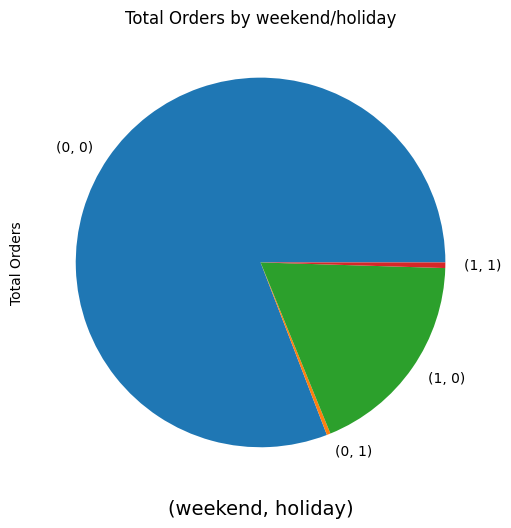

In [185]:
# plot the orders
df_by_month = train_df.groupby(['is_weekend', 'holiday'])['orders'].sum()
df_by_month.plot(kind='pie', figsize=(12, 6))

plt.title('Total Orders by weekend/holiday')
plt.ylabel('Total Orders')
plt.xlabel('(weekend, holiday)', fontdict={'fontsize': 14})
plt.show()

#### Compare feature Colerations

In [186]:
#train_df_corr = train_df.drop(columns=['warehouse', "id", 'holiday_name']).corr()
train_df_corr = train_df.drop(columns=['warehouse', "id"]).corr()

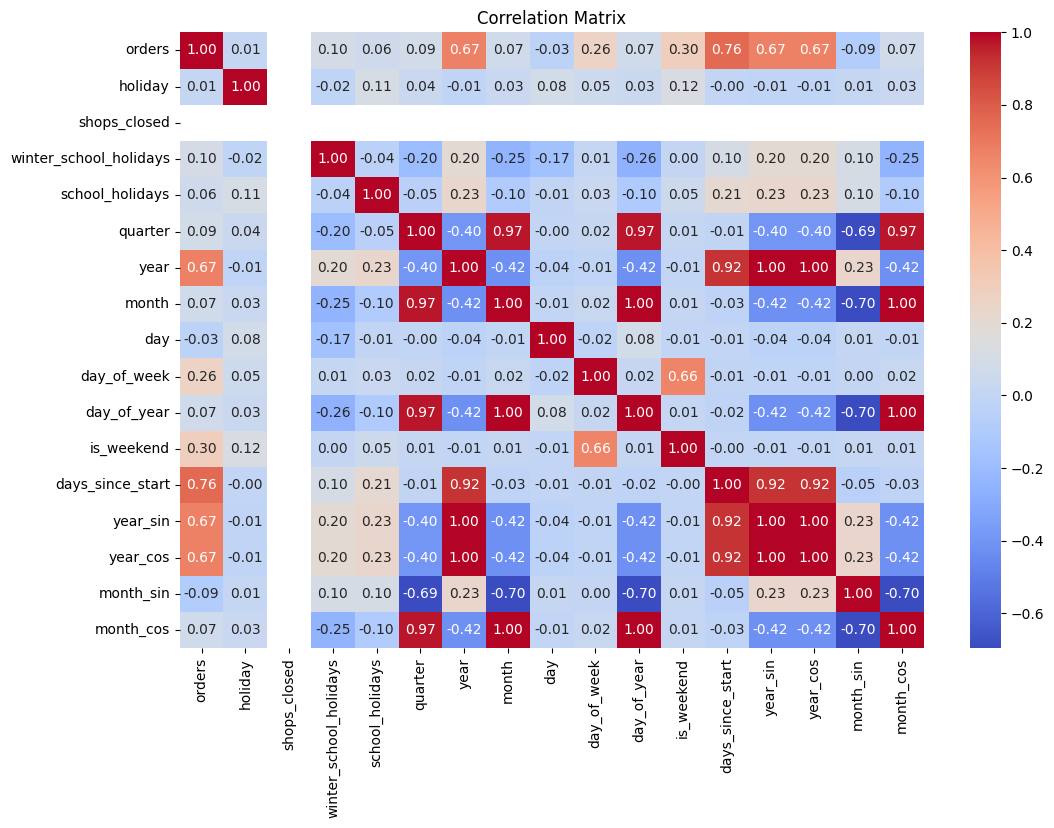

orders                    1.000000
days_since_start          0.759556
year                      0.669330
year_cos                  0.669330
year_sin                  0.669324
is_weekend                0.295338
day_of_week               0.258182
winter_school_holidays    0.096082
quarter                   0.085218
month                     0.071119
month_cos                 0.071119
day_of_year               0.070436
school_holidays           0.063368
holiday                   0.011311
day                      -0.034679
month_sin                -0.091821
shops_closed                   NaN
Name: orders, dtype: float64


In [187]:
import seaborn as sns
import matplotlib.pyplot as plt
# Plot the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(train_df_corr, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

# Print the correlation with 'orders'
print(train_df_corr['orders'].sort_values(ascending=False))

### Remove Outliers

#### Time Series Cross Validation



In [188]:
from sklearn.model_selection import TimeSeriesSplit

tss = TimeSeriesSplit(n_splits=3, test_size=398, gap=1) # gap - 24house between train gata end - test data start
cross_val_train_df = train_df.sort_index()

In [189]:
"""
fig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True)

fold = 0
for train_idx, test_idx in tss.split(cross_val_train_df):
    train = cross_val_train_df.iloc[train_idx]
    test = cross_val_train_df.iloc[test_idx]
    
    ax[fold].plot(train.index, train['orders'], label='Train')
    ax[fold].plot(test.index, test['orders'], label='Test')
    ax[fold].set_title(f"Fold {fold}")
    ax[fold].axvline(train.index[-1], color='r', linestyle='--', lw=2)
    
    fold += 1

plt.show()
"""

'\nfig, ax = plt.subplots(3, 1, figsize=(15, 15), sharex=True)\n\nfold = 0\nfor train_idx, test_idx in tss.split(cross_val_train_df):\n    train = cross_val_train_df.iloc[train_idx]\n    test = cross_val_train_df.iloc[test_idx]\n    \n    ax[fold].plot(train.index, train[\'orders\'], label=\'Train\')\n    ax[fold].plot(test.index, test[\'orders\'], label=\'Test\')\n    ax[fold].set_title(f"Fold {fold}")\n    ax[fold].axvline(train.index[-1], color=\'r\', linestyle=\'--\', lw=2)\n    \n    fold += 1\n\nplt.show()\n'

### Temporal features

In [190]:
train_df.head()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos
date,,,,,,,,,,,,,,,,,,,
2022-02-18,Frankfurt_1,1499.068362,0,0,0,0,Frankfurt_1_2022-02-18,1,2022,2,18,4,49,0,0,-2.639248e-09,2022.0,-9.797174e-16,2.0
2022-02-19,Frankfurt_1,1499.068362,0,0,0,0,Frankfurt_1_2022-02-19,1,2022,2,19,5,50,1,1,-2.639248e-09,2022.0,-9.797174e-16,2.0
2022-02-23,Frankfurt_1,945.000000,0,0,0,0,Frankfurt_1_2022-02-23,1,2022,2,23,2,54,0,5,-2.639248e-09,2022.0,-9.797174e-16,2.0
2022-02-24,Frankfurt_1,955.000000,0,0,0,0,Frankfurt_1_2022-02-24,1,2022,2,24,3,55,0,6,-2.639248e-09,2022.0,-9.797174e-16,2.0
2022-02-25,Frankfurt_1,1022.000000,0,0,0,0,Frankfurt_1_2022-02-25,1,2022,2,25,4,56,0,7,-2.639248e-09,2022.0,-9.797174e-16,2.0


In [191]:
LAG_DAYS = [28, 56, 168, 364]
ROLLING_WINDOW = [28, 168, 364]

In [192]:
# Create lag features
def create_lag_features(df, col, lag_days):
    lag_features = []
    # create lag features for each warehouse, stop at the last dataset day even if the lag is not complete
    for lag in lag_days:
        df[f'{col}_lag_{lag}'] = df.groupby('warehouse')[col].shift(lag)
        lag_features.append(f'{col}_lag_{lag}')
    return df, lag_features


# Create rolling statistics
def create_rolling_features(df, col, windows):
    window_features = []
    # create rolling features for each warehouse, stop at the last dataset day even if the lag is not complete
    for window in windows:
        df[f'{col}_rolling_mean_{window}'] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).mean())
        df[f'{col}_rolling_std_{window}'] = df.groupby('warehouse')[col].transform(lambda x: x.rolling(window, min_periods=1).std())
        window_features.extend([f'{col}_rolling_mean_{window}', f'{col}_rolling_std_{window}'])
    return df, window_features


In [193]:
# Apply the functions
train_df, lag_features = create_lag_features(train_df, 'orders', LAG_DAYS)
train_df, window_features = create_rolling_features(train_df, 'orders', ROLLING_WINDOW)

# Combine the features for easier visualization
numerical_features = ['orders']
numerical_features += lag_features + window_features
#categorical_features=categorical_features + ['warehouse', 'holiday_name']
categorical_features=categorical_features + ['warehouse']

print(numerical_features)

train_df.head()

['orders', 'orders_lag_28', 'orders_lag_56', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']


,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-18,Frankfurt_1,1499.068362,0,0,0,0,Frankfurt_1_2022-02-18,1,2022,2,18,4,49,0,0,-2.639248e-09,2022.0,-9.797174e-16,2.0,NaN,NaN,NaN,NaN,1499.068362,NaN,1499.068362,NaN,1499.068362,NaN
2022-02-19,Frankfurt_1,1499.068362,0,0,0,0,Frankfurt_1_2022-02-19,1,2022,2,19,5,50,1,1,-2.639248e-09,2022.0,-9.797174e-16,2.0,NaN,NaN,NaN,NaN,1499.068362,0.000000,1499.068362,0.000000,1499.068362,0.000000
2022-02-23,Frankfurt_1,945.000000,0,0,0,0,Frankfurt_1_2022-02-23,1,2022,2,23,2,54,0,5,-2.639248e-09,2022.0,-9.797174e-16,2.0,NaN,NaN,NaN,NaN,1314.378908,319.891518,1314.378908,319.891518,1314.378908,319.891518
2022-02-24,Frankfurt_1,955.000000,0,0,0,0,Frankfurt_1_2022-02-24,1,2022,2,24,3,55,0,6,-2.639248e-09,2022.0,-9.797174e-16,2.0,NaN,NaN,NaN,NaN,1224.534181,317.031054,1224.534181,317.031054,1224.534181,317.031054
2022-02-25,Frankfurt_1,1022.000000,0,0,0,0,Frankfurt_1_2022-02-25,1,2022,2,25,4,56,0,7,-2.639248e-09,2022.0,-9.797174e-16,2.0,NaN,NaN,NaN,NaN,1184.027345,289.111632,1184.027345,289.111632,1184.027345,289.111632


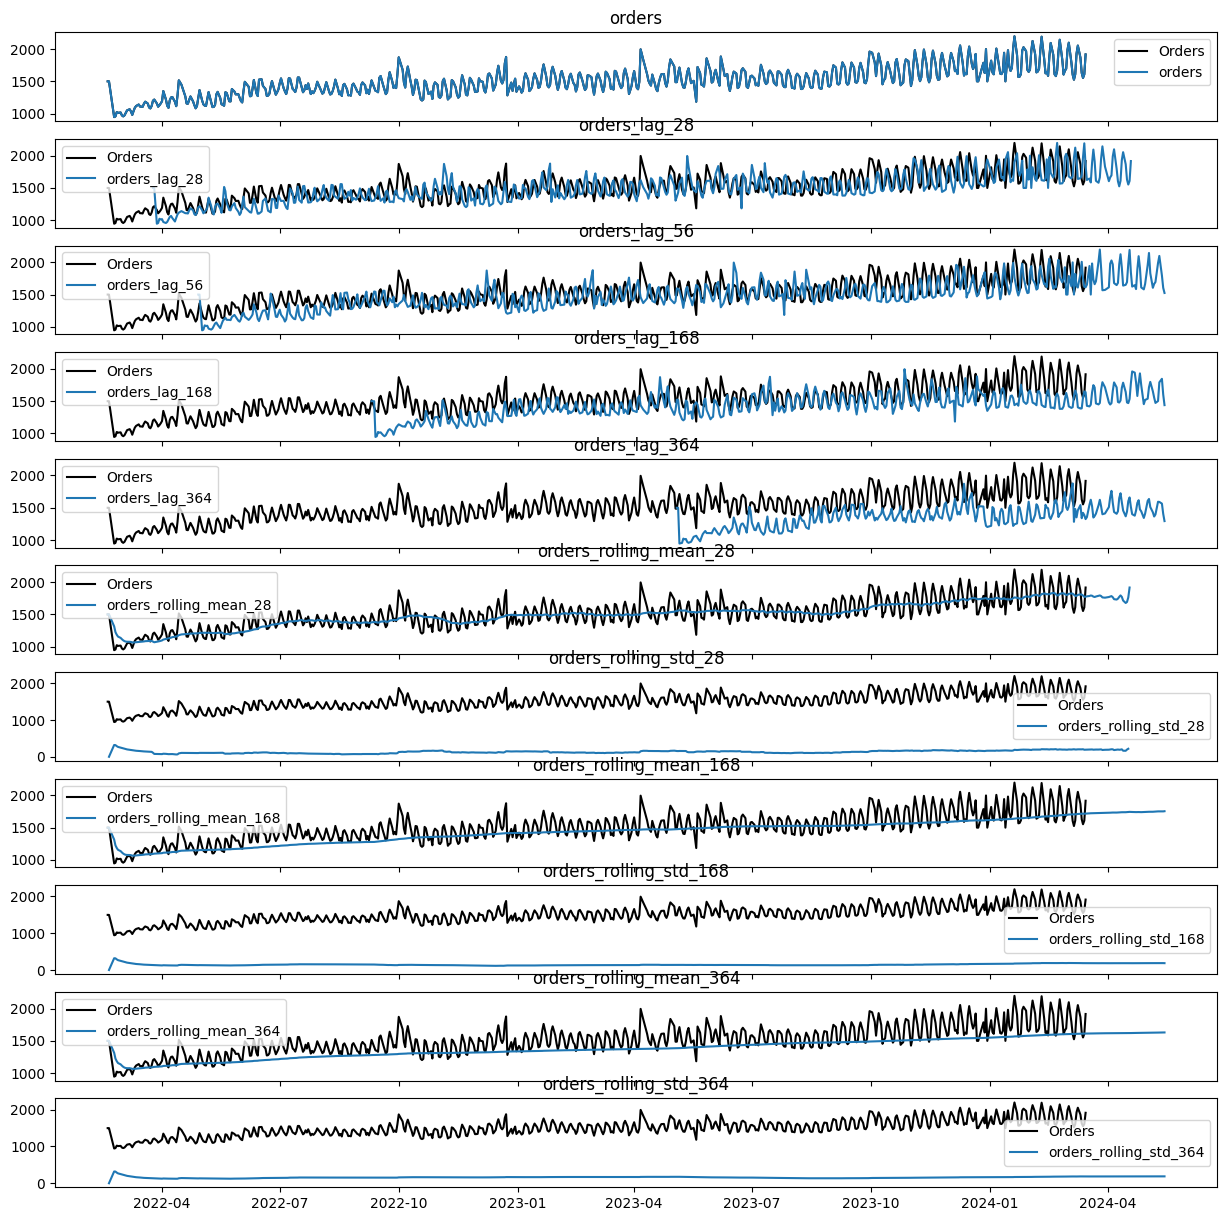

In [194]:
#orders and features above each other
fig, ax = plt.subplots(len(numerical_features), 1, figsize=(15, 15), sharex=True)
for i, feature in enumerate(numerical_features):
    ax[i].plot(train_df.index, train_df['orders'], label='Orders', color='black')
    ax[i].plot(train_df.index, train_df[feature], label=feature)
    ax[i].set_title(feature)
    ax[i].legend()
plt.show()


In [195]:
"""
# make plots for every warehouse with with lag 98 feature
feature = f'orders_lag_{LAG_DAYS[0]}'

fig, ax = plt.subplots(len(train_df['warehouse'].unique()), 1, figsize=(15, 15), sharex=True)
for i, warehouse in enumerate(train_df['warehouse'].unique()):
    warehouse_df = train_df[train_df['warehouse'] == warehouse]
    ax[i].plot(warehouse_df.index, warehouse_df['orders'], label='Orders', color='black')
    ax[i].plot(warehouse_df.index, warehouse_df[feature], label=feature)
    ax[i].set_title(warehouse)
    ax[i].legend()
plt.show()
"""

"\n# make plots for every warehouse with with lag 98 feature\nfeature = f'orders_lag_{LAG_DAYS[0]}'\n\nfig, ax = plt.subplots(len(train_df['warehouse'].unique()), 1, figsize=(15, 15), sharex=True)\nfor i, warehouse in enumerate(train_df['warehouse'].unique()):\n    warehouse_df = train_df[train_df['warehouse'] == warehouse]\n    ax[i].plot(warehouse_df.index, warehouse_df['orders'], label='Orders', color='black')\n    ax[i].plot(warehouse_df.index, warehouse_df[feature], label=feature)\n    ax[i].set_title(warehouse)\n    ax[i].legend()\nplt.show()\n"

In [196]:
# divide dataset back into train and test datasets according to the dates from the original datasets:
test_date_range = (test_df_merged.date.min(), test_df_merged.date.max())
train_date_range = (train_df_merged.date.min(), train_df_merged.date.max())

test_df = train_df.loc[(train_df.index >= test_date_range[0]) & (train_df.index <= test_date_range[1])]
test_df["date"] = test_df.index
test_df = test_df.drop(columns=['orders'])
train_df = train_df.loc[(train_df.index >= train_date_range[0]) & (train_df.index <= train_date_range[1])]

C:\Users\ondre\AppData\Local\Temp\ipykernel_22244\1761043157.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  test_df["date"] = test_df.index


In [197]:
train_df.tail()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2024-03-11,Frankfurt_1,1867.0,0,0,0,0,Frankfurt_1_2024-03-11,1,2024,3,11,0,71,0,752,3.208798e-11,2024.0,-2.204364e-15,3.0,1650.0,1820.0,1385.0,1541.0,1809.500000,200.260479,1714.084961,188.067787,1609.138114,185.386774
2024-03-12,Frankfurt_1,1629.0,0,0,0,0,Frankfurt_1_2024-03-12,1,2024,3,12,1,72,0,753,3.208798e-11,2024.0,-2.204364e-15,3.0,1692.0,2007.0,1387.0,1338.0,1807.250000,201.976094,1715.525437,186.467501,1609.937564,184.840955
2024-03-13,Frankfurt_1,1552.0,0,0,0,0,Frankfurt_1_2024-03-13,1,2024,3,13,2,73,0,754,3.208798e-11,2024.0,-2.204364e-15,3.0,1979.0,1751.0,1558.0,1421.0,1792.000000,204.630652,1715.489723,186.498424,1610.297455,184.599448
2024-03-14,Frankfurt_1,1608.0,0,0,0,0,Frankfurt_1_2024-03-14,1,2024,3,14,3,74,0,755,3.208798e-11,2024.0,-2.204364e-15,3.0,2191.0,1619.0,1650.0,1386.0,1771.178571,191.785577,1715.239723,186.614853,1610.907345,184.222704
2024-03-15,Frankfurt_1,1916.0,0,0,0,0,Frankfurt_1_2024-03-15,1,2024,3,15,4,75,0,756,3.208798e-11,2024.0,-2.204364e-15,3.0,1844.0,1611.0,1639.0,1324.0,1773.750000,193.275015,1716.888532,187.160114,1612.533718,184.295984


In [198]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (629, 29)
Test data: (48, 29)


In [199]:
test_df.to_csv('data/test_proc_mt.csv')

In [200]:
train_df = train_df.drop(columns=['id'])

### OH encoding of categorical features

In [201]:
from sklearn.preprocessing import OneHotEncoder
import joblib

# Initialize OneHotEncoder
encoder = OneHotEncoder(handle_unknown='ignore', sparse=False)

# Fit the encoder on 'warehouse' and 'holiday_name' columns
encoded_features = encoder.fit_transform(train_df[categorical_features])

# Get the encoded feature names
encoded_feature_names = encoder.get_feature_names_out(categorical_features)
    
# Create a DataFrame with the encoded features
encoded_df = pd.DataFrame(encoded_features, columns=encoded_feature_names)

if 'holiday_name_nan' in encoded_df.columns:
    encoded_df = encoded_df.drop(columns=['holiday_name_nan'])
    encoded_feature_names = encoded_feature_names.tolist()
    encoded_feature_names.remove('holiday_name_nan')
print(encoded_feature_names)    

encoded_df.index = train_df.index

# Concatenate the encoded features with the original DataFrame
train_df = pd.concat([train_df, encoded_df], axis=1)

# Save the encoder
joblib.dump(encoder, 'scaler_onehot_categorical_mt.joblib')

['day_of_week_0' 'day_of_week_1' 'day_of_week_2' 'day_of_week_3'
 'day_of_week_4' 'day_of_week_5' 'quarter_1' 'quarter_2' 'quarter_3'
 'quarter_4' 'year_2022' 'year_2023' 'year_2024' 'warehouse_Frankfurt_1']


c:\Users\ondre\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\preprocessing\_encoders.py:975: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


['scaler_onehot_categorical_mt.joblib']

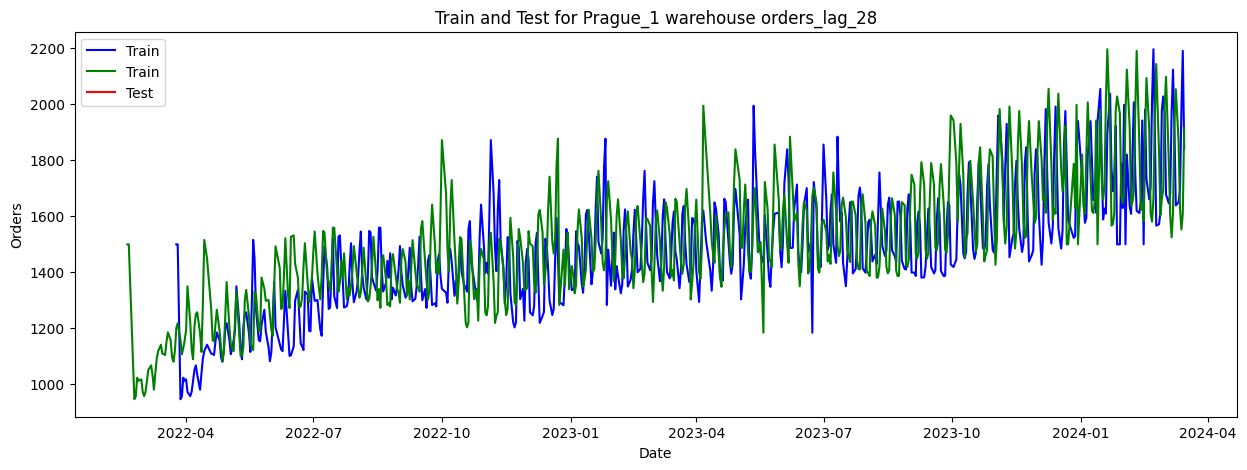

In [202]:
# plot the train and test datasets and visualise them in diferent colors for only column of prague_1 warehouse
feature = f'orders_lag_{LAG_DAYS[0]}'

plt.figure(figsize=(15, 5)) 
datax = train_df[train_df[f'warehouse_{WAREHOUSE}'] == 1]
datax_test = test_df[test_df['warehouse'] == 'Prague_1']
plt.plot(datax.index, datax[feature], label='Train', color='blue')
plt.plot(datax.index, datax['orders'], label='Train', color='green')
plt.plot(datax_test.index, datax_test[feature], label='Test', color='red')


plt.title(f'Train and Test for Prague_1 warehouse {feature}')

plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()

### Min-Max scale numerical features

In [203]:
print(f"Train data: {train_df.shape}")
print(f"Test data: {test_df.shape}")

Train data: (629, 42)
Test data: (48, 29)


In [204]:
print(train_df.isna().sum())  # Check for Nas

warehouse                    0
orders                       0
holiday                      0
shops_closed                 0
winter_school_holidays       0
school_holidays              0
quarter                      0
year                         0
month                        0
day                          0
day_of_week                  0
day_of_year                  0
is_weekend                   0
days_since_start             0
year_sin                     0
year_cos                     0
month_sin                    0
month_cos                    0
orders_lag_28               28
orders_lag_56               56
orders_lag_168             168
orders_lag_364             364
orders_rolling_mean_28       0
orders_rolling_std_28        1
orders_rolling_mean_168      0
orders_rolling_std_168       1
orders_rolling_mean_364      0
orders_rolling_std_364       1
day_of_week_0                0
day_of_week_1                0
day_of_week_2                0
day_of_week_3                0
day_of_w

In [205]:
# Save all scaler features into singe json scaler config file:
scaler_config = {
    'num_features': numerical_features,
    'cat_features': categorical_features,
    'time_features': time_features,
}

joblib.dump(scaler_config, 'scaler_config_mt.joblib')

['scaler_config_mt.joblib']

In [206]:
train_df = train_df.fillna(0)

In [207]:
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())        

Start Date: 2022-02-18 00:00:00
End Date: 2024-03-15 00:00:00


In [208]:
"""drop nan values of these columns 
orders_lag_98                                                                
orders_lag_196                                                             
orders_lag_364                                                              
orders_rolling_mean_98                                                         
orders_rolling_std_98                                                          
orders_rolling_mean_364                                                        
orders_rolling_std_364     
"""
subset = []
for feature in numerical_features:
    if 'lag' in feature or 'rolling' in feature:
        subset.append(feature)
print(subset)
#train_df = train_df.dropna(subset=subset)
                     
print("Start Date:", train_df.index.min())
print("End Date:", train_df.index.max())                               

['orders_lag_28', 'orders_lag_56', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']
Start Date: 2022-02-18 00:00:00
End Date: 2024-03-15 00:00:00


In [209]:
train_df.head()

,warehouse,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,quarter_1,quarter_2,quarter_3,quarter_4,year_2022,year_2023,year_2024,warehouse_Frankfurt_1
date,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
2022-02-18,Frankfurt_1,1499.068362,0,0,0,0,1,2022,2,18,4,49,0,0,-2.639248e-09,2022.0,-9.797174e-16,2.0,0.0,0.0,0.0,0.0,1499.068362,0.000000,1499.068362,0.000000,1499.068362,0.000000,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2022-02-19,Frankfurt_1,1499.068362,0,0,0,0,1,2022,2,19,5,50,1,1,-2.639248e-09,2022.0,-9.797174e-16,2.0,0.0,0.0,0.0,0.0,1499.068362,0.000000,1499.068362,0.000000,1499.068362,0.000000,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2022-02-23,Frankfurt_1,945.000000,0,0,0,0,1,2022,2,23,2,54,0,5,-2.639248e-09,2022.0,-9.797174e-16,2.0,0.0,0.0,0.0,0.0,1314.378908,319.891518,1314.378908,319.891518,1314.378908,319.891518,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2022-02-24,Frankfurt_1,955.000000,0,0,0,0,1,2022,2,24,3,55,0,6,-2.639248e-09,2022.0,-9.797174e-16,2.0,0.0,0.0,0.0,0.0,1224.534181,317.031054,1224.534181,317.031054,1224.534181,317.031054,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
2022-02-25,Frankfurt_1,1022.000000,0,0,0,0,1,2022,2,25,4,56,0,7,-2.639248e-09,2022.0,-9.797174e-16,2.0,0.0,0.0,0.0,0.0,1184.027345,289.111632,1184.027345,289.111632,1184.027345,289.111632,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0


In [210]:
train_df.describe()

,orders,holiday,shops_closed,winter_school_holidays,school_holidays,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,quarter_1,quarter_2,quarter_3,quarter_4,year_2022,year_2023,year_2024,warehouse_Frankfurt_1
count,629.000000,629.000000,629.0,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,6.290000e+02,629.000000,6.290000e+02,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.000000,629.0
mean,1496.224817,0.007949,0.0,0.027027,0.038156,2.453100,2022.685215,6.387917,15.709062,2.543720,178.812401,0.171701,379.915739,-1.724347e-09,2022.685215,-1.940035e-14,6.387917,1417.266153,1336.149987,1037.659995,563.057451,1483.438717,131.752042,1416.699663,143.015465,1366.056140,156.471404,0.155803,0.165342,0.171701,0.165342,0.170111,0.171701,0.278219,0.230525,0.251192,0.240064,0.416534,0.481717,0.101749,1.0
std,223.153612,0.088873,0.0,0.162291,0.191725,1.134201,0.647967,3.469923,8.783286,1.699591,105.945124,0.377421,218.238375,8.653133e-10,0.647967,2.841548e-14,3.469923,371.923678,460.683598,644.767281,669.118750,180.680595,38.820928,167.453209,24.385397,140.096335,21.804499,0.362957,0.371784,0.377421,0.371784,0.376030,0.377421,0.448479,0.421504,0.434044,0.427462,0.493377,0.500063,0.302558,0.0
min,945.000000,0.000000,0.0,0.000000,0.000000,1.000000,2022.000000,1.000000,1.000000,0.000000,2.000000,0.000000,0.000000,-2.639248e-09,2022.000000,-1.077962e-13,1.000000,0.000000,0.000000,0.000000,0.000000,1063.946045,0.000000,1063.946045,0.000000,1063.946045,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
25%,1358.000000,0.000000,0.0,0.000000,0.000000,1.000000,2022.000000,3.000000,8.000000,1.000000,81.000000,0.000000,192.000000,-2.639248e-09,2022.000000,-1.983928e-14,3.000000,1333.000000,1298.000000,0.000000,0.000000,1383.892857,105.022415,1272.777247,129.754066,1272.777247,146.012424,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
50%,1480.000000,0.000000,0.0,0.000000,0.000000,2.000000,2023.000000,6.000000,16.000000,3.000000,179.000000,0.000000,378.000000,-1.304240e-09,2023.000000,-8.817457e-15,6.000000,1458.000000,1436.000000,1349.000000,0.000000,1495.892857,123.959772,1449.607143,136.778085,1363.546173,156.920496,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.0
75%,1624.000000,0.000000,0.0,0.000000,0.000000,3.000000,2023.000000,9.000000,23.000000,4.000000,270.000000,0.000000,568.000000,-1.304240e-09,2023.000000,-2.204364e-15,9.000000,1611.000000,1580.000000,1487.000000,1303.000000,1562.178571,159.446973,1529.523810,151.421206,1479.997253,167.609304,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,1.000000,0.000000,1.000000,1.000000,0.000000,1.0
max,2197.000000,1.000000,0.0,1.000000,1.000000,4.000000,2024.000000,12.000000,31.000000,5.000000,365.000000,1.000000,756.000000,3.208798e-11,2024.000000,-2.449294e-16,12.000000,2197.000000,2055.000000,1995.000000,1877.000000,1832.142857,319.891518,1716.888532,319.891518,1612.533718,319.891518,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.0


In [211]:
# check non-continuos date timeline
train_df.index.to_series().diff().value_counts()

date
1 days    512
2 days    106
3 days      8
4 days      2
Name: count, dtype: int64

### Create Time Series 

In [212]:
X_train = train_df.drop(columns=['orders'])
y_train = train_df['orders']

In [213]:
X_train.shape, y_train.shape

((629, 41), (629,))

In [214]:
warehouse = X_train['warehouse']
X_train= X_train.drop(columns=categorical_features)

In [215]:
#Standard Scaler:
from sklearn.preprocessing import StandardScaler

# Initialize the scaler
x_scaler = StandardScaler()
y_scaler = StandardScaler()

# Fit the scaler on the numeriacal columns
X_train_scaled = pd.DataFrame(x_scaler.fit_transform(X_train), columns=X_train.columns)
#X_train_scaled = x_scaler.fit_transform(X_train)
y_train_scaled = y_scaler.fit_transform(y_train.values.reshape(-1, 1))

# Save the scaler
joblib.dump(x_scaler, 'x_scaler_mt.joblib')
joblib.dump(y_scaler, 'y_scaler_mt.joblib')


['y_scaler_mt.joblib']

In [216]:
warehouse = warehouse.reset_index(drop=True)

In [217]:
train_df_warehouse = pd.concat([X_train_scaled, warehouse], axis=1)

In [218]:
X_train_scaled.max()

holiday                    11.171392
shops_closed                0.000000
winter_school_holidays      6.000000
school_holidays             5.020790
month                       1.618638
day                         1.742299
day_of_year                 1.758795
is_weekend                  2.196377
days_since_start            1.724644
year_sin                    2.031441
year_cos                    2.030709
month_sin                   0.674656
month_cos                   1.618638
orders_lag_28               2.098157
orders_lag_56               1.561640
orders_lag_168              1.485965
orders_lag_364              1.965254
orders_rolling_mean_28      1.931484
orders_rolling_std_28       4.850199
orders_rolling_mean_168     1.794100
orders_rolling_std_168      7.259132
orders_rolling_mean_364     1.760744
orders_rolling_std_364      7.500754
day_of_week_0               2.327739
day_of_week_1               2.246793
day_of_week_2               2.196377
day_of_week_3               2.246793
d

In [219]:
time_steps = 1

In [220]:
# Create sequences for each warehouse
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator

sequences = []
targets = []

for warehouse in train_df_warehouse['warehouse'].unique():
    warehouse_data = X_train_scaled[train_df_warehouse['warehouse'] == warehouse]
    
    if len(warehouse_data) > time_steps:
        generator = TimeseriesGenerator(X_train_scaled.values, 
                                        y_train_scaled, 
                                        length=time_steps, 
                                        batch_size=1)
        
        for i in range(len(generator)):
            x, y = generator[i]
            sequences.append(x)
            targets.append(y)

X = np.array(sequences)
y = np.array(targets)

X.shape, y.shape

((628, 1, 1, 37), (628, 1, 1))

In [221]:
X = np.squeeze(X, axis=1)
y = np.squeeze(y, axis=1)
# 4.1%

In [222]:
"""
def create_sequences(X, y, time_steps=30):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i + time_steps)])
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

X, y = create_sequences(X_train_scaled, y_train_scaled, time_steps)

X.shape, y.shape
"""

'\ndef create_sequences(X, y, time_steps=30):\n    Xs, ys = [], []\n    for i in range(len(X) - time_steps):\n        Xs.append(X[i:(i + time_steps)])\n        ys.append(y[i + time_steps])\n    return np.array(Xs), np.array(ys)\n\nX, y = create_sequences(X_train_scaled, y_train_scaled, time_steps)\n\nX.shape, y.shape\n'

### Data Loading

In [223]:
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, shuffle=True)  

### Compile and Fit the model

In [224]:
import numpy as np
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dropout, Dense, Bidirectional, BatchNormalization, Input
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

LR = 1e-3
checkpointing = ModelCheckpoint('best_model_lstm_ms.h5', save_best_only=True, monitor='val_loss', mode='min', verbose=1)
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

"""
model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(units=1))

"""

model = Sequential()
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(Bidirectional(LSTM(units=64, return_sequences=True)))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(units=32, return_sequences=True))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(LSTM(units=16, return_sequences=False))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(Dense(units=1))

model.compile(loss=MeanSquaredError(), optimizer=Adam(learning_rate=LR))

history = model.fit(X_train, y_train, epochs=200, batch_size=16, verbose=1, validation_data=(X_val, y_val), callbacks=[checkpointing])

Epoch 1/200
30/32 [===========================>..] - ETA: 0s - loss: 1.8616
Epoch 1: val_loss improved from inf to 1.01418, saving model to best_model_lstm_ms.h5
32/32 [==============================] - 8s 67ms/step - loss: 1.8365 - val_loss: 1.0142
Epoch 2/200
31/32 [============================>.] - ETA: 0s - loss: 1.1429
Epoch 2: val_loss improved from 1.01418 to 0.98308, saving model to best_model_lstm_ms.h5
32/32 [==============================] - 1s 24ms/step - loss: 1.1634 - val_loss: 0.9831
Epoch 3/200
29/32 [==========================>...] - ETA: 0s - loss: 0.9180
Epoch 3: val_loss improved from 0.98308 to 0.95944, saving model to best_model_lstm_ms.h5
32/32 [==============================] - 1s 22ms/step - loss: 0.9301 - val_loss: 0.9594
Epoch 4/200
30/32 [===========================>..] - ETA: 0s - loss: 0.8465
Epoch 4: val_loss improved from 0.95944 to 0.92431, saving model to best_model_lstm_ms.h5
32/32 [==============================] - 1s 20ms/step - loss: 0.8618 - val_l

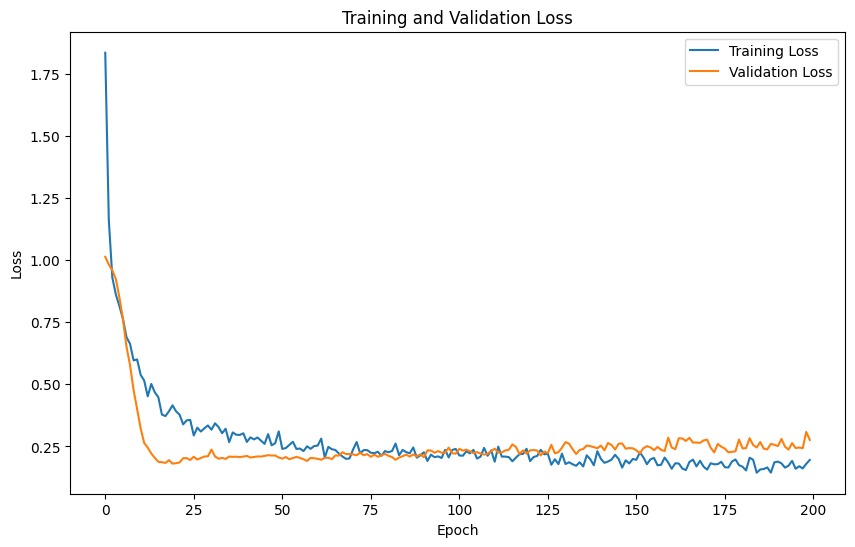

In [225]:
# Plot the training and validation loss
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

## Inference

#### MAPE

In [226]:
from sklearn.metrics import mean_absolute_percentage_error
# Evaluate the model on the validation set
model = tf.keras.models.load_model('best_model_lstm_ms.h5')

val_predictions = model.predict(X_val)
val_predictions = y_scaler.inverse_transform(val_predictions)
y_val_unscaled = y_scaler.inverse_transform(y_val)

mape = mean_absolute_percentage_error(y_val_unscaled, val_predictions) * 100
print(f'Tuned Model Mean Absolute Percentage Error: {mape:.4f}%')

4/4 [==============================] - 1s 6ms/step
Tuned Model Mean Absolute Percentage Error: 4.2244%


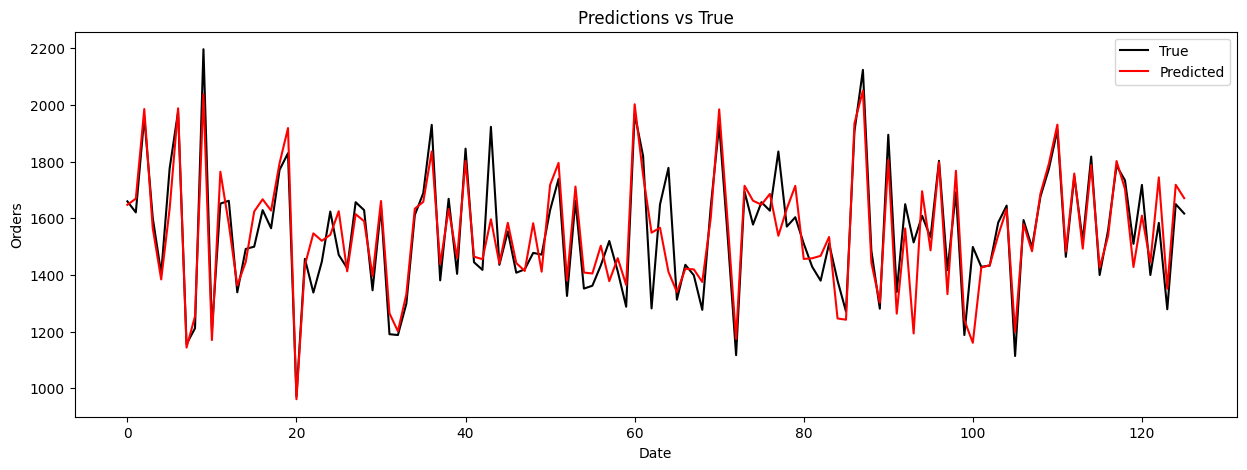

In [227]:
# Visualise the predictions in compare to the same dates in the training data in year 2023
plt.figure(figsize=(15, 5))
plt.plot(y_val_unscaled, label='True', color='black')
plt.plot(val_predictions, label='Predicted', color='red')
plt.title('Predictions vs True')
plt.xlabel('Date')
plt.ylabel('Orders')
plt.legend()
plt.show()


In [228]:
import pandas as pd
import joblib

dataframe = pd.read_csv("data/test_proc_mt.csv")

In [229]:
dataframe.head(10)

,date,warehouse,holiday,shops_closed,winter_school_holidays,school_holidays,id,quarter,year,month,day,day_of_week,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,date.1
0,2024-03-16,Frankfurt_1,0,0,0,0,Frankfurt_1_2024-03-16,1,2024,3,16,5,76,1,757,3.208798e-11,2024.0,-2.204364e-15,3.0,1623.0,1652.000000,1427.0,1354.0,1779.333333,194.642078,1718.624392,186.361631,1613.245932,184.048056,2024-03-16
1,2024-03-18,Frankfurt_1,0,0,0,0,Frankfurt_1_2024-03-18,1,2024,3,18,0,78,0,759,3.208798e-11,2024.0,-2.204364e-15,3.0,1645.0,1942.000000,1418.0,1547.0,1784.500000,196.599542,1720.435382,185.445731,1613.428932,184.269720,2024-03-18
2,2024-03-19,Frankfurt_1,0,0,0,0,Frankfurt_1_2024-03-19,1,2024,3,19,1,79,0,760,3.208798e-11,2024.0,-2.204364e-15,3.0,1584.0,1499.068362,1445.0,1624.0,1792.520000,196.264728,1722.104688,184.755033,1613.399649,184.524630,2024-03-19
3,2024-03-20,Frankfurt_1,0,0,0,0,Frankfurt_1_2024-03-20,1,2024,3,20,2,80,0,761,3.208798e-11,2024.0,-2.204364e-15,3.0,1888.0,1981.000000,1635.0,1524.0,1788.541667,199.453597,1722.635814,185.194505,1613.647982,184.721031,2024-03-20
4,2024-03-21,Frankfurt_1,0,0,0,0,Frankfurt_1_2024-03-21,1,2024,3,21,3,81,0,762,3.208798e-11,2024.0,-2.204364e-15,3.0,2094.0,1734.000000,1748.0,1348.0,1775.260870,192.780897,1722.480205,185.754459,1614.387948,184.443767,2024-03-21
5,2024-03-22,Frankfurt_1,0,0,0,0,Frankfurt_1_2024-03-22,1,2024,3,22,4,82,0,763,3.208798e-11,2024.0,-2.204364e-15,3.0,1912.0,1660.000000,1713.0,1372.0,1769.045455,194.944553,1722.538725,186.328936,1615.065010,184.254620,2024-03-22
6,2024-03-23,Frankfurt_1,0,0,0,1,Frankfurt_1_2024-03-23,1,2024,3,23,5,83,1,764,3.208798e-11,2024.0,-2.204364e-15,3.0,1609.0,1706.000000,1464.0,1409.0,1776.666667,196.371671,1724.144556,185.782410,1615.642223,184.188810,2024-03-23
7,2024-03-25,Frankfurt_1,0,0,0,1,Frankfurt_1_2024-03-25,1,2024,3,25,0,85,0,766,3.208798e-11,2024.0,-2.204364e-15,3.0,1580.0,2014.000000,1449.0,1538.0,1786.500000,196.096781,1725.864209,185.075863,1615.860319,184.401881,2024-03-25
8,2024-03-26,Frankfurt_1,0,0,0,1,Frankfurt_1_2024-03-26,1,2024,3,26,1,86,0,767,3.208798e-11,2024.0,-2.204364e-15,3.0,1662.0,2197.000000,1471.0,1623.0,1793.052632,199.208008,1727.467129,184.543135,1615.840207,184.661761,2024-03-26
9,2024-03-27,Frankfurt_1,0,0,0,1,Frankfurt_1_2024-03-27,1,2024,3,27,2,87,0,768,3.208798e-11,2024.0,-2.204364e-15,3.0,1958.0,1907.000000,1675.0,1520.0,1783.888889,200.820344,1727.799199,185.082258,1616.110942,184.852569,2024-03-27


In [230]:
import os
xsc = joblib.load(os.path.join("x_scaler_mt.joblib"))
ysc = joblib.load(os.path.join("y_scaler_mt.joblib"))
ohsc = joblib.load(os.path.join("scaler_onehot_categorical_mt.joblib"))

In [231]:
# load scaler config:
scaler_config = joblib.load('scaler_config_mt.joblib')

num_features = scaler_config['num_features']
cat_features = scaler_config['cat_features']
time_features = scaler_config['time_features']
    
print(f"num_features: {num_features}")
print(f"cat_features: {cat_features}")
print(f"time_features: {time_features}")

num_features: ['orders', 'orders_lag_28', 'orders_lag_56', 'orders_lag_168', 'orders_lag_364', 'orders_rolling_mean_28', 'orders_rolling_std_28', 'orders_rolling_mean_168', 'orders_rolling_std_168', 'orders_rolling_mean_364', 'orders_rolling_std_364']
cat_features: ['day_of_week', 'quarter', 'year', 'warehouse']
time_features: ['day', 'days_since_start', 'month', 'day_of_year', 'year_sin', 'year_cos', 'month_sin', 'month_cos']


In [232]:
from working import preprocess_data
id = dataframe.pop('id')
dataframe.drop(columns=['date.1'], inplace=True)
processed_data = preprocess_data(dataframe, xsc, ohsc, cat_features)

In [233]:
processed_data.head()     

,holiday,shops_closed,winter_school_holidays,school_holidays,month,day,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,quarter_1,quarter_2,quarter_3,quarter_4,year_2022,year_2023,year_2024,warehouse_Frankfurt_1
0,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.033150,-0.971203,2.196377,1.729230,2.031441,2.030709,0.605644,-0.977144,0.553602,0.686157,0.604326,1.183007,1.638970,1.621293,1.804474,1.778961,1.765832,1.265730,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,2.196377,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
1,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.261037,-0.952310,-0.455295,1.738402,2.031441,2.030709,0.605644,-0.977144,0.612801,1.316158,0.590357,1.471675,1.667589,1.671756,1.815298,1.741372,1.767139,1.275904,2.327739,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
2,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.374980,-0.942864,-0.455295,1.742987,2.031441,2.030709,0.605644,-0.977144,0.448658,0.353926,0.632266,1.586844,1.712012,1.663124,1.825275,1.713025,1.766930,1.287604,-0.429601,2.246793,-0.455295,-0.445079,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
3,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.488923,-0.933418,-0.455295,1.747573,2.031441,2.030709,0.605644,-0.977144,1.266681,1.400882,0.927180,1.437275,1.689975,1.745333,1.828449,1.731061,1.768704,1.296618,-0.429601,-0.445079,2.196377,-0.445079,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
4,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.602866,-0.923971,-0.455295,1.752159,2.031441,2.030709,0.605644,-0.977144,1.820998,0.864295,1.102577,1.174033,1.616413,1.573312,1.827519,1.754042,1.773990,1.283892,-0.429601,-0.445079,-0.455295,2.246793,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0


In [234]:
processed_data.shape

(48, 37)

In [235]:
# Compare the columns in the original and processed dataframes

X_columns = set(train_df.columns)
processed_data_columns = set(processed_data.columns)

if X_columns == processed_data_columns:
    print("this df has the same columns as the training df.")
else:
    print("The dataframes have different columns.")

    columns_only_in_X = X_columns - processed_data_columns
    columns_only_in_processed_data = processed_data_columns - X_columns

    if columns_only_in_X:
        print("Columns present only in train_df:")
        print(columns_only_in_X)

    if columns_only_in_processed_data:
        print("Columns present only in processed_data:")
        print(columns_only_in_processed_data)

The dataframes have different columns.
Columns present only in train_df:
{'year', 'orders', 'warehouse', 'day_of_week', 'quarter'}


In [236]:
processed_data = processed_data.fillna(0)

In [237]:
processed_data.head(10)

,holiday,shops_closed,winter_school_holidays,school_holidays,month,day,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,quarter_1,quarter_2,quarter_3,quarter_4,year_2022,year_2023,year_2024,warehouse_Frankfurt_1
0,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.033150,-0.971203,2.196377,1.729230,2.031441,2.030709,0.605644,-0.977144,0.553602,0.686157,0.604326,1.183007,1.638970,1.621293,1.804474,1.778961,1.765832,1.265730,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,2.196377,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
1,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.261037,-0.952310,-0.455295,1.738402,2.031441,2.030709,0.605644,-0.977144,0.612801,1.316158,0.590357,1.471675,1.667589,1.671756,1.815298,1.741372,1.767139,1.275904,2.327739,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
2,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.374980,-0.942864,-0.455295,1.742987,2.031441,2.030709,0.605644,-0.977144,0.448658,0.353926,0.632266,1.586844,1.712012,1.663124,1.825275,1.713025,1.766930,1.287604,-0.429601,2.246793,-0.455295,-0.445079,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
3,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.488923,-0.933418,-0.455295,1.747573,2.031441,2.030709,0.605644,-0.977144,1.266681,1.400882,0.927180,1.437275,1.689975,1.745333,1.828449,1.731061,1.768704,1.296618,-0.429601,-0.445079,2.196377,-0.445079,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
4,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.602866,-0.923971,-0.455295,1.752159,2.031441,2.030709,0.605644,-0.977144,1.820998,0.864295,1.102577,1.174033,1.616413,1.573312,1.827519,1.754042,1.773990,1.283892,-0.429601,-0.445079,-0.455295,2.246793,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
5,-0.089514,0.0,-0.166667,-0.199172,-0.977144,0.716810,-0.914525,-0.455295,1.756745,2.031441,2.030709,0.605644,-0.977144,1.331261,0.703537,1.048250,1.209929,1.581985,1.629090,1.827869,1.777619,1.778826,1.275211,-0.429601,-0.445079,-0.455295,-0.445079,2.208734,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
6,-0.089514,0.0,-0.166667,5.020790,-0.977144,0.830753,-0.905079,2.196377,1.761331,2.031441,2.030709,0.605644,-0.977144,0.515930,0.803468,0.661757,1.265270,1.624199,1.665881,1.837466,1.755189,1.782950,1.272190,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,2.196377,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
7,-0.089514,0.0,-0.166667,5.020790,-0.977144,1.058639,-0.886186,-0.455295,1.770502,2.031441,2.030709,0.605644,-0.977144,0.437895,1.472571,0.638474,1.458214,1.678667,1.658795,1.847744,1.726192,1.784508,1.281970,2.327739,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
8,-0.089514,0.0,-0.166667,5.020790,-0.977144,1.172583,-0.876739,-0.455295,1.775088,2.031441,2.030709,0.605644,-0.977144,0.658545,1.870123,0.672622,1.585348,1.714962,1.739001,1.857324,1.704328,1.784364,1.293898,-0.429601,2.246793,-0.455295,-0.445079,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0
9,-0.089514,0.0,-0.166667,5.020790,-0.977144,1.286526,-0.867293,-0.455295,1.779674,2.031441,2.030709,0.605644,-0.977144,1.455041,1.240123,0.989267,1.431292,1.664204,1.780567,1.859308,1.726454,1.786298,1.302656,-0.429601,-0.445079,2.196377,-0.445079,-0.452748,-0.455295,1.610679,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216,0.0


In [238]:
processed_data.describe()

,holiday,shops_closed,winter_school_holidays,school_holidays,month,day,day_of_year,is_weekend,days_since_start,year_sin,year_cos,month_sin,month_cos,orders_lag_28,orders_lag_56,orders_lag_168,orders_lag_364,orders_rolling_mean_28,orders_rolling_std_28,orders_rolling_mean_168,orders_rolling_std_168,orders_rolling_mean_364,orders_rolling_std_364,day_of_week_0,day_of_week_1,day_of_week_2,day_of_week_3,day_of_week_4,day_of_week_5,quarter_1,quarter_2,quarter_3,quarter_4,year_2022,year_2023,year_2024,warehouse_Frankfurt_1
count,48.000000,48.0,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,4.800000e+01,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,48.000000,4.800000e+01,48.0
mean,0.145088,0.0,-0.166667,1.649565,-0.694732,0.018908,-0.687812,0.041893,1.866804,2.031441e+00,2.030709,0.542563,-0.694732,0.559562,1.013154,0.910915,1.399758,0.887981,0.866649,1.913870,1.756177,1.817905,1.354603,0.029955,0.059647,-0.013350,-0.052514,-0.064615,0.041893,-0.062973,1.233414,-0.579186,-0.562049,-0.844924,-0.964079,2.971216e+00,0.0
std,1.625372,0.0,0.000000,2.522918,0.201671,0.967019,0.166742,1.045933,0.080946,4.487887e-16,0.000000,0.048314,0.201671,0.619508,0.434425,0.242689,0.169013,0.810179,0.831633,0.055799,0.035193,0.033271,0.051198,1.038474,1.061789,0.998678,0.960120,0.949281,1.045933,0.976508,1.039002,0.000000,0.000000,0.000000,0.000000,4.487887e-16,0.0
min,-0.089514,0.0,-0.166667,-0.199172,-0.977144,-1.562055,-0.971203,-0.455295,1.729230,2.031441e+00,2.030709,0.467621,-0.977144,0.000000,0.353926,0.590357,1.091770,0.000000,0.000000,1.804474,1.694312,1.765832,1.265730,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,-0.620856,-0.547345,-0.579186,-0.562049,-0.844924,-0.964079,2.971216e+00,0.0
25%,-0.089514,0.0,-0.166667,-0.199172,-0.760829,-0.792938,-0.817700,-0.455295,1.803749,2.031441e+00,2.030709,0.545259,-0.760829,0.000000,0.667149,0.681159,1.260409,0.000000,0.000000,1.865017,1.727125,1.793778,1.302988,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,-0.620856,1.233414,-0.579186,-0.562049,-0.844924,-0.964079,2.971216e+00,0.0
50%,-0.089514,0.0,-0.166667,-0.199172,-0.688724,0.033150,-0.683089,-0.455295,1.869097,2.031441e+00,2.030709,0.545259,-0.688724,0.474221,0.833881,0.901569,1.389412,1.320568,1.079091,1.925478,1.753415,1.813882,1.362967,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,-0.620856,1.827001,-0.579186,-0.562049,-0.844924,-0.964079,2.971216e+00,0.0
75%,-0.089514,0.0,-0.166667,5.020790,-0.688724,0.830753,-0.553202,-0.455295,1.932151,2.031441e+00,2.030709,0.560355,-0.688724,1.039975,1.379158,1.113054,1.537112,1.617931,1.659877,1.952436,1.777954,1.846848,1.399804,-0.429601,-0.445079,-0.455295,-0.445079,-0.452748,-0.455295,-0.062973,1.827001,-0.579186,-0.562049,-0.844924,-0.964079,2.971216e+00,0.0
max,11.171392,0.0,-0.166667,5.020790,-0.400303,1.628355,-0.404421,2.196377,2.004378,2.031441e+00,2.030709,0.605644,-0.400303,1.955542,1.870123,1.431639,1.793249,2.395971,2.218013,2.014917,1.832691,1.884030,1.437230,2.327739,2.246793,2.196377,2.246793,2.208734,2.196377,1.610679,1.827001,-0.579186,-0.562049,-0.844924,-0.964079,2.971216e+00,0.0


In [239]:
test_columns = processed_data.columns
time_steps = 1

In [240]:
"""
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
import numpy as np
import pandas as pd

def pad_and_predict(model, data, time_steps, feature_columns):
    padded_data = data[feature_columns].copy()
    
    # Pad the beginning with the first row
    padding = pd.DataFrame([padded_data.iloc[0]] * (time_steps - 1), columns=padded_data.columns)
    padded_data = pd.concat([padding, padded_data]).reset_index(drop=True)
    
    dummy_targets = np.zeros(len(padded_data))
    
    generator = TimeseriesGenerator(padded_data.values, dummy_targets,
                                    length=time_steps, batch_size=1)
    
    predictions = model.predict(generator)
    
    return predictions[:len(data)]  # Return only predictions for actual data points


predictions = pad_and_predict(model, processed_data, time_steps, test_columns)

submission_df = pd.DataFrame({'id': id[:len(predictions)], 'orders': predictions.flatten()})
submission_df.to_csv('submission_padded_generator.csv', index=False)
"""

"\nfrom tensorflow.keras.preprocessing.sequence import TimeseriesGenerator\nimport numpy as np\nimport pandas as pd\n\ndef pad_and_predict(model, data, time_steps, feature_columns):\n    padded_data = data[feature_columns].copy()\n    \n    # Pad the beginning with the first row\n    padding = pd.DataFrame([padded_data.iloc[0]] * (time_steps - 1), columns=padded_data.columns)\n    padded_data = pd.concat([padding, padded_data]).reset_index(drop=True)\n    \n    dummy_targets = np.zeros(len(padded_data))\n    \n    generator = TimeseriesGenerator(padded_data.values, dummy_targets,\n                                    length=time_steps, batch_size=1)\n    \n    predictions = model.predict(generator)\n    \n    return predictions[:len(data)]  # Return only predictions for actual data points\n\n\npredictions = pad_and_predict(model, processed_data, time_steps, test_columns)\n\nsubmission_df = pd.DataFrame({'id': id[:len(predictions)], 'orders': predictions.flatten()})\nsubmission_df.to_csv

In [241]:
import numpy as np
import pandas as pd

def variable_length_predict(model, data, max_time_steps, feature_columns):
    predictions = []
    for i in range(len(data)):
        seq_len = min(max_time_steps, i+1)
        sequence = data[feature_columns].iloc[max(0, i-seq_len+1):i+1]
        
        if len(sequence) < max_time_steps:
            padding = pd.DataFrame([sequence.iloc[0]] * (max_time_steps - len(sequence)), 
                                   columns=sequence.columns)
            sequence = pd.concat([padding, sequence]).reset_index(drop=True)
        
        # Reshape the sequence for the model
        model_input = sequence.values.reshape(1, max_time_steps, -1)
        
        # Make prediction
        pred = model.predict(model_input)
        predictions.append(pred[0][0])
    
    return np.array(predictions)

predictions = variable_length_predict(model, processed_data, time_steps, test_columns)

predictions = predictions.reshape(-1, 1)

submission_df = pd.DataFrame({'id': id[:len(predictions)], 'orders': predictions.flatten()})
submission_df.to_csv('submission_variable_length.csv', index=False)


1/1 [==============================] - 0s 26ms/step


In [242]:
"""
import numpy as np
import pandas as pd

def rolling_forecast(model, data, time_steps, feature_columns, target_column='orders'):
    predictions = []
    current_data = data.copy()
    
    for i in range(len(data)):
        if i < time_steps - 1:
            sequence = np.tile(current_data[feature_columns].iloc[0].values, (time_steps, 1))
            sequence[-(i+1):] = current_data[feature_columns].iloc[:i+1].values
        else:
            sequence = current_data[feature_columns].iloc[i-time_steps+1:i+1].values
        
        model_input = sequence.reshape(1, time_steps, -1)
        
        # Make prediction
        pred = model.predict(model_input)[0][0]
        
        # Check for NaN prediction
        if np.isnan(pred):
            print(f"NaN prediction at step {i}")
            print("Input sequence:")
            print(sequence)
            # Use the last non-NaN prediction or 0 if it's the first prediction
            pred = predictions[-1] if predictions else 0
        
        predictions.append(pred)
        
        # Print every 100th prediction for monitoring
        if i % 100 == 0:
            print(f"Step {i}, Prediction: {pred}")
            print("Input features:")
            print(current_data[feature_columns].iloc[i])
            print("\n")
        
        # Update the data for the next prediction
        if i + 1 < len(data):
            current_data.loc[current_data.index[i+1], target_column] = pred
            
            for lag in [28, 56, 168, 364]:
                if i + 1 - lag >= 0:
                    current_data.loc[current_data.index[i+1], f'orders_lag_{lag}'] = current_data.loc[current_data.index[i+1-lag], target_column]
            
            window = min(28, i + 2)
            current_data.loc[current_data.index[i+1], 'orders_rolling_mean_28'] = current_data[target_column].iloc[max(0, i+2-window):i+2].mean()
            current_data.loc[current_data.index[i+1], 'orders_rolling_std_28'] = current_data[target_column].iloc[max(0, i+2-window):i+2].std()
            
            for col in feature_columns:
                if 'rolling_mean' in col or 'rolling_std' in col:
                    window_size = int(col.split('_')[-1])
                    if 'mean' in col:
                        current_data.loc[current_data.index[i+1], col] = current_data[target_column].iloc[max(0, i+2-window_size):i+2].mean()
                    elif 'std' in col:
                        current_data.loc[current_data.index[i+1], col] = current_data[target_column].iloc[max(0, i+2-window_size):i+2].std()
    
    return np.array(predictions)

# Usage
predictions = rolling_forecast(model, processed_data, time_steps, test_columns)

# Reshape predictions for inverse transform
predictions = predictions.reshape(-1, 1)

# Create submission DataFrame
submission_df = pd.DataFrame({'id': id[:len(predictions)], 'orders': predictions.flatten()})
submission_df.to_csv('submission_rolling_forecast.csv', index=False)

# Print first few predictions to verify
print("First few predictions:")
print(predictions[:10])
"""

'\nimport numpy as np\nimport pandas as pd\n\ndef rolling_forecast(model, data, time_steps, feature_columns, target_column=\'orders\'):\n    predictions = []\n    current_data = data.copy()\n    \n    for i in range(len(data)):\n        if i < time_steps - 1:\n            sequence = np.tile(current_data[feature_columns].iloc[0].values, (time_steps, 1))\n            sequence[-(i+1):] = current_data[feature_columns].iloc[:i+1].values\n        else:\n            sequence = current_data[feature_columns].iloc[i-time_steps+1:i+1].values\n        \n        model_input = sequence.reshape(1, time_steps, -1)\n        \n        # Make prediction\n        pred = model.predict(model_input)[0][0]\n        \n        # Check for NaN prediction\n        if np.isnan(pred):\n            print(f"NaN prediction at step {i}")\n            print("Input sequence:")\n            print(sequence)\n            # Use the last non-NaN prediction or 0 if it\'s the first prediction\n            pred = predictions[-1]

In [243]:
X = np.squeeze(X, axis=1)

In [244]:
import tensorflow as tf
model = tf.keras.models.load_model('best_model_lstm_ms.h5')

In [245]:
# predictions = model.predict(X_infer)

In [246]:
predictions.shape  

(48, 1)

In [247]:
# Rescale the predictions to original scale:
predictions_rescaled = ysc.inverse_transform(predictions)

#put the predictions into the dataframe with "id" and "orders" columns
submission_df = pd.DataFrame({'id': id[:len(predictions)], 'orders': predictions_rescaled.flatten()})

submission_df.to_csv('submission_rescaled_mt.csv', index=False)
submission_df.head()

,id,orders
0,Frankfurt_1_2024-03-16,1904.172607
1,Frankfurt_1_2024-03-18,1755.639404
2,Frankfurt_1_2024-03-19,1636.345581
3,Frankfurt_1_2024-03-20,1751.776489
4,Frankfurt_1_2024-03-21,1972.172852


In [248]:
# Add the date column as an index and warehouse column to the rescaled predictions 
submission_df['date'] = dataframe['date']
submission_df['warehouse'] = dataframe['warehouse']
submission_df.tail(10)

,id,orders,date,warehouse
38,Frankfurt_1_2024-05-03,1980.047974,2024-05-03,Frankfurt_1
39,Frankfurt_1_2024-05-04,1853.828735,2024-05-04,Frankfurt_1
40,Frankfurt_1_2024-05-06,1621.474731,2024-05-06,Frankfurt_1
41,Frankfurt_1_2024-05-07,1686.261108,2024-05-07,Frankfurt_1
42,Frankfurt_1_2024-05-08,1715.714478,2024-05-08,Frankfurt_1
43,Frankfurt_1_2024-05-10,1979.330200,2024-05-10,Frankfurt_1
44,Frankfurt_1_2024-05-11,1862.688599,2024-05-11,Frankfurt_1
45,Frankfurt_1_2024-05-13,1640.341309,2024-05-13,Frankfurt_1
46,Frankfurt_1_2024-05-14,1685.318481,2024-05-14,Frankfurt_1
47,Frankfurt_1_2024-05-15,1701.629028,2024-05-15,Frankfurt_1


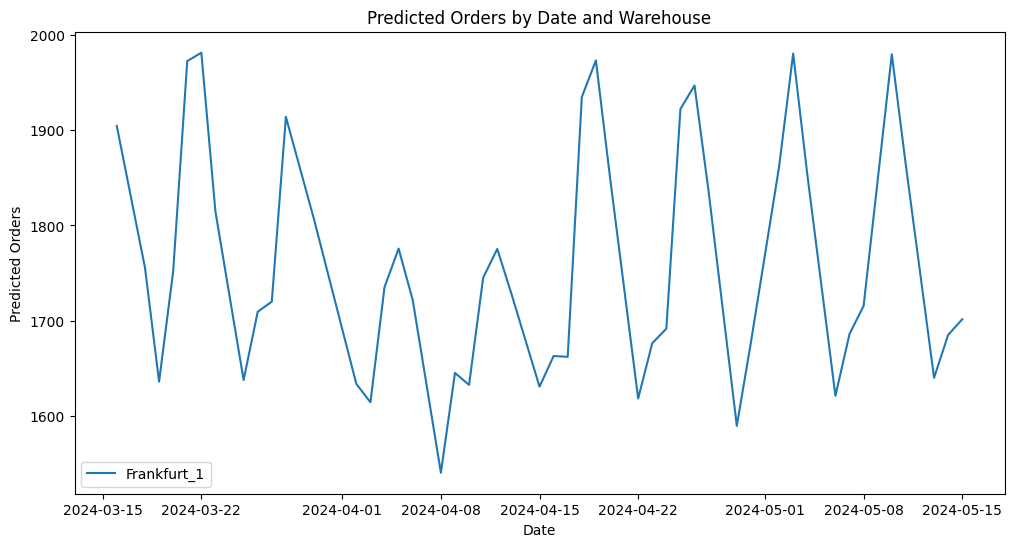

In [249]:
import matplotlib.pyplot as plt
# Visualise rescaled predictions with date for every warehouse on the same plot
warehouses = submission_df['warehouse'].unique()
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=wh)
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()

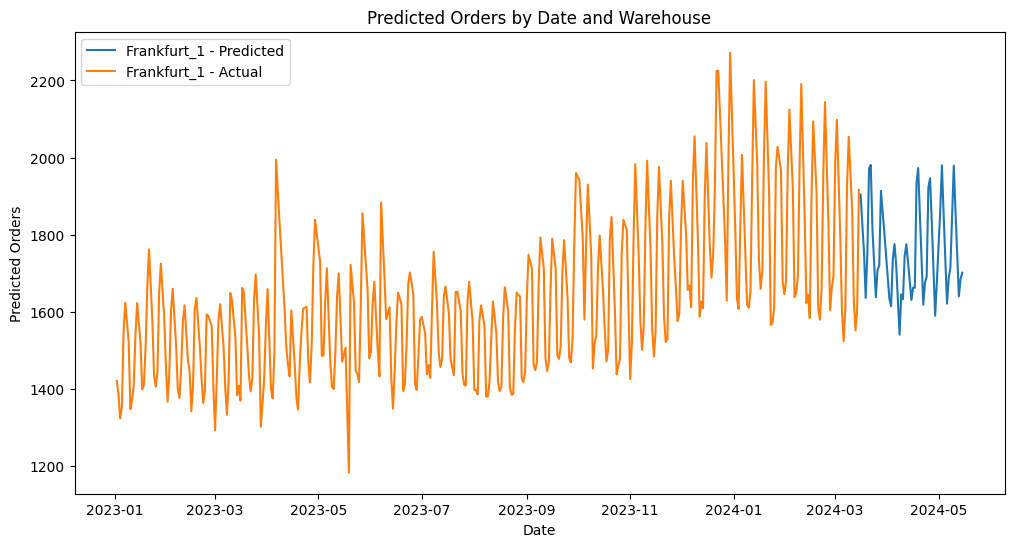

In [250]:
# Visualise the predictions in compare to the same dates in the training data in year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year > 2022]
plt.figure(figsize=(12, 6))
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    plt.plot(wh_df['date'], wh_df['orders'], label=f'{wh} - Predicted')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label=f'{wh} - Actual')
    
plt.title('Predicted Orders by Date and Warehouse')
plt.xlabel('Date')
plt.ylabel('Predicted Orders')
plt.legend()

plt.show()


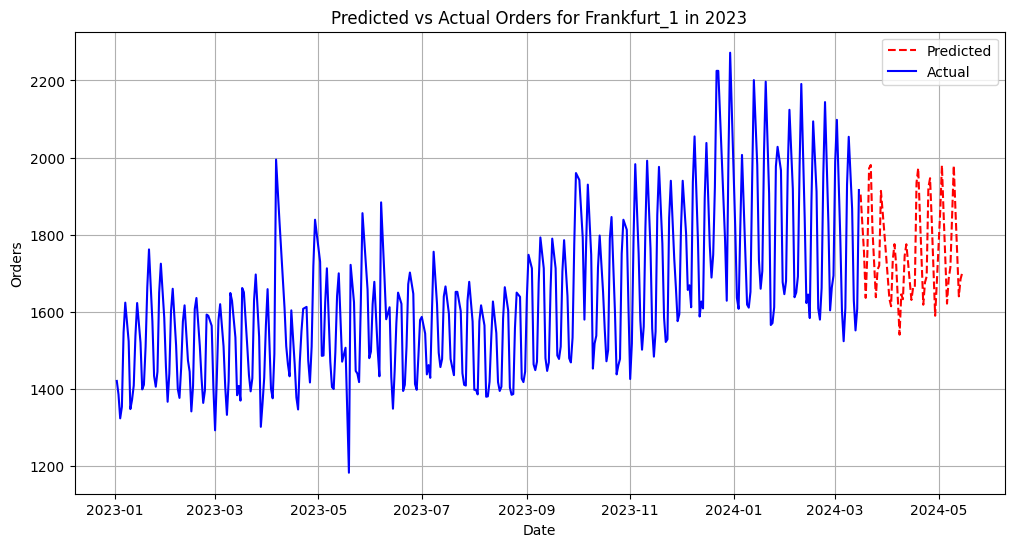

In [251]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming these dataframes are already loaded
# train_df_raw: Raw training data
# submission_df_rescaled: Rescaled predictions
# warehouses: List of warehouse names

# Filter training data for the year 2023
train_df_2023 = train_df_raw[train_df_raw['date'].dt.year > 2022]

# Create separate plots for each warehouse
for wh in warehouses:
    wh_df = submission_df[submission_df['warehouse'] == wh]
    wh_df_train = train_df_2023[train_df_2023['warehouse'] == wh]
    
    plt.figure(figsize=(12, 6))
    plt.plot(wh_df['date'], wh_df['orders'], label='Predicted', linestyle='--', color='r')
    plt.plot(wh_df_train['date'], wh_df_train['orders'], label='Actual', color='b')
    plt.title(f'Predicted vs Actual Orders for {wh} in 2023')
    plt.xlabel('Date')
    plt.ylabel('Orders')
    plt.legend()
    plt.grid(True)
    plt.show()
